In [1]:
import copy
import functools
import itertools as it
import logging
import random
import sys
import typing

from hstrat import _auxiliary_lib as hstrat_aux
import interval_search as inch
from IPython.core.display import display, HTML
from matplotlib import pyplot as plt
import matplotlib as mpl
from nbmetalog import nbmetalog as nbm
import numpy as np
import opytional as opyt
import pandas as pd
import pytest
from scipy import stats as scipy_stats
import seaborn as sns
from teeplot import teeplot as tp
from tqdm import tqdm

from hsurf.hsurf import steady_try_algo as steady_algo
from hsurf import site_selection_strategy
import pylib

random.seed(1)

logging.basicConfig(
    format="[%(funcName)s:%(lineno)d] %(message)s",
)
logger = logging.getLogger()

pylib.jupyter_hide_toggle(hide=True)


<IPython.core.display.Javascript object>

In [2]:
mpl.rcParams.update(
    {
        "figure.figsize": (6, 1),
    },
)


In [3]:
nbm.print_metadata()

pylib.jupyter_hide_toggle(hide=True)


context: ci
hostname: fv-az1780-522
interpreter: 3.10.12 (main, Mar 22 2024, 16:50:05) [GCC 11.4.0]
nbcellexec: null
nbname: 11-steady-try-surface
nbpath: /home/runner/work/hstrat-surface-concept/hstrat-surface-concept/binder/11-steady-try-surface.ipynb
revision: null
session: 8bcbe13b-a71b-4dd1-a1fd-974113dfe570
timestamp: 2024-07-18T01:20:28Z00:00


IPython==7.31.1
keyname==0.5.2
yaml==6.0
hstrat==1.11.1
hsurf==0.3.0
interval_search==0.5.2
logging==0.5.1.2
matplotlib==3.8.3
nbmetalog==0.2.6
numpy==1.23.5
opytional==0.1.0
pandas==1.5.2
pytest==7.2.2
scipy==1.10.1
seaborn==0.13.2
teeplot==1.0.1
re==2.2.1
comm==0.1.3
psutil==5.9.5
zmq==25.1.0
json==2.0.9
ipykernel==6.23.3


<IPython.core.display.Javascript object>

# Section 2: evaluate `get_ingest_site_at_rank`


## Section 2a: Visualize Steady Criterion Satisfaction


100%|██████████| 255/255 [00:00<00:00, 5998.65it/s]


teeplots/11/hue=kind+surface-size=8+viz=criterion-satisfaction-lineplot+x=rank+y=steady-criterion+yscale=symlog+ext=.pdf
teeplots/11/hue=kind+surface-size=8+viz=criterion-satisfaction-lineplot+x=rank+y=steady-criterion+yscale=symlog+ext=.png


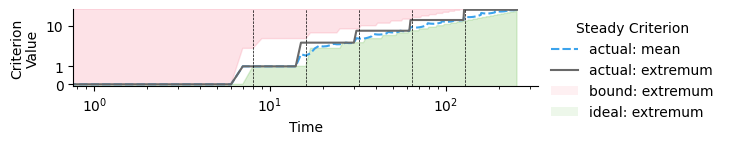

100%|██████████| 65535/65535 [00:11<00:00, 5899.43it/s]


teeplots/11/hue=kind+surface-size=16+viz=criterion-satisfaction-lineplot+x=rank+y=steady-criterion+yscale=symlog+ext=.pdf
teeplots/11/hue=kind+surface-size=16+viz=criterion-satisfaction-lineplot+x=rank+y=steady-criterion+yscale=symlog+ext=.png


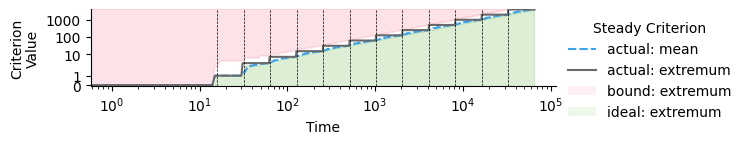

100%|██████████| 65536/65536 [00:11<00:00, 5835.76it/s]


teeplots/11/hue=kind+surface-size=32+viz=criterion-satisfaction-lineplot+x=rank+y=steady-criterion+yscale=symlog+ext=.pdf
teeplots/11/hue=kind+surface-size=32+viz=criterion-satisfaction-lineplot+x=rank+y=steady-criterion+yscale=symlog+ext=.png


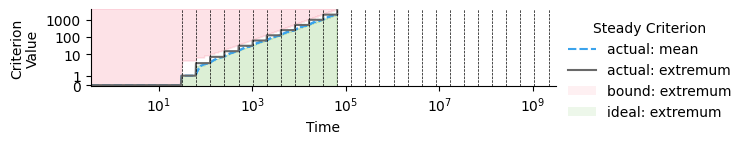

In [4]:
for surface_size in 8, 16, 32:
    surface_history_df = pylib.site_selection_eval.make_surface_history_df(
        steady_algo.pick_ingest_site,
        surface_size=surface_size,
        num_generations=min(2**surface_size - 1, 2**16),
        progress_wrap=tqdm,
    )
    criteria_df = pylib.site_selection_eval.calc_surface_history_criteria(
        surface_history_df,
        steady_algo,
        site_selection_strategy.site_selection_bounds,
        site_selection_strategy.site_selection_criteria,
        progress_wrap=tqdm,
    )
    pylib.tee_release(
        pylib.site_selection_viz.criterion_satisfaction_lineplot,
        data=criteria_df[
            ~criteria_df["kind"].isin(["naive lower bound"])
        ],
        x="rank",
        y="steady criterion",
        hue="kind",
        surface_size=surface_size,
        yscale="symlog",
        teeplot_outinclude="surface_size",
        teeplot_subdir="11",
    )


## Section 2b: Visualize Reservations


100%|██████████| 255/255 [00:00<00:00, 94474.65it/s]


teeplots/11/reservation-mode=steady+surface-size=8+viz=site-reservation-at-ranks-heatmap+ext=.pdf
teeplots/11/reservation-mode=steady+surface-size=8+viz=site-reservation-at-ranks-heatmap+ext=.png


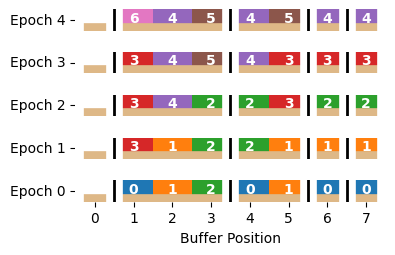

100%|██████████| 65535/65535 [00:00<00:00, 137560.32it/s]


teeplots/11/reservation-mode=steady+surface-size=16+viz=site-reservation-at-ranks-heatmap+ext=.pdf
teeplots/11/reservation-mode=steady+surface-size=16+viz=site-reservation-at-ranks-heatmap+ext=.png


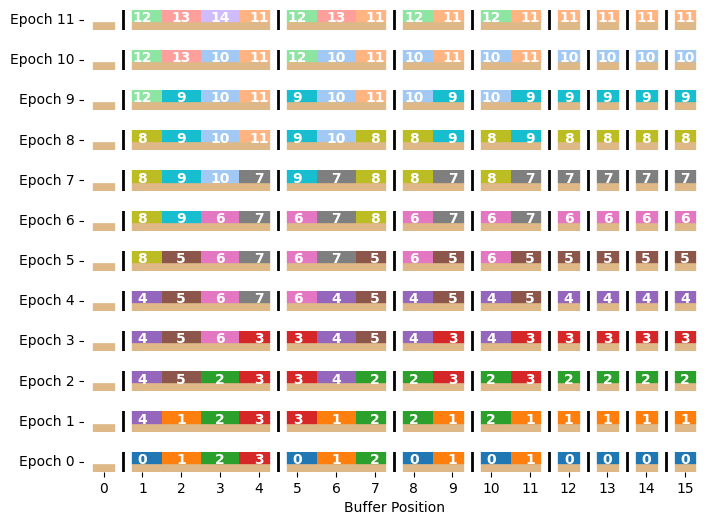

100%|██████████| 262144/262144 [00:03<00:00, 74675.56it/s]


teeplots/11/reservation-mode=steady+surface-size=32+viz=site-reservation-at-ranks-heatmap+ext=.pdf
teeplots/11/reservation-mode=steady+surface-size=32+viz=site-reservation-at-ranks-heatmap+ext=.png


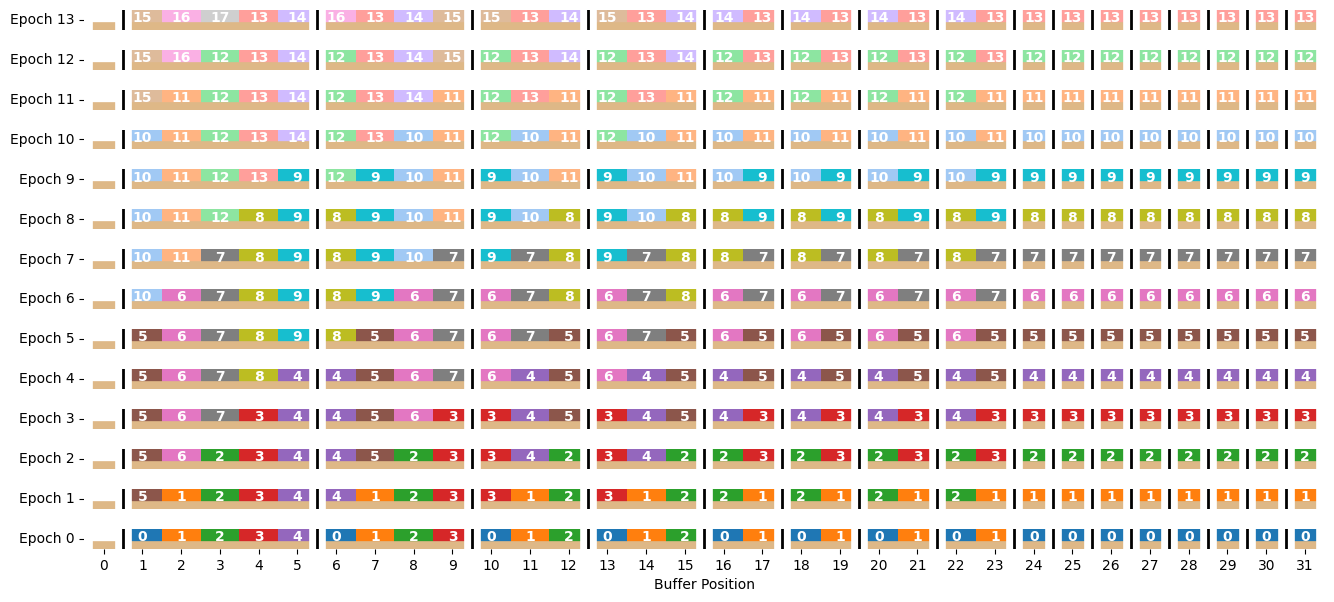

In [5]:
for surface_size in 8, 16, 32:
    surface_history_df = pylib.site_selection_eval.make_surface_history_df(
        steady_algo.pick_ingest_site,
        surface_size=surface_size,
        num_generations=min(2**surface_size - 1, 2**18),
        progress_wrap=tqdm,
    ).replace(-1, np.nan)

    candidate_ranks = [
        2**i - 2 for i in range(surface_size.bit_length() - 1, surface_size)
    ]
    maxrank = surface_history_df["rank"].max()
    ranks = [
        rank - 2**i + 1 for i, rank in enumerate(candidate_ranks)
        if rank <= maxrank  # in operator weird, nan?
    ]
    pylib.tee_release(
        pylib.site_selection_viz.site_reservation_at_ranks_heatmap,
        surface_history_df,
        ranks=ranks,
        reservation_mode="steady",
        zigzag=False,
        teeplot_outattrs={"surface-size": surface_size},
        teeplot_subdir="11",
    )
    plt.show()


100%|██████████| 127/127 [00:00<00:00, 55626.21it/s]
3it [00:04,  1.55s/it]
3it [00:00,  3.20it/s]


teeplots/11/num-generations=128+reservation-mode=steady+surface-size=32+viz=site-reservation-by-rank-spliced-at-heatmap+ext=.pdf
teeplots/11/num-generations=128+reservation-mode=steady+surface-size=32+viz=site-reservation-by-rank-spliced-at-heatmap+ext=.png


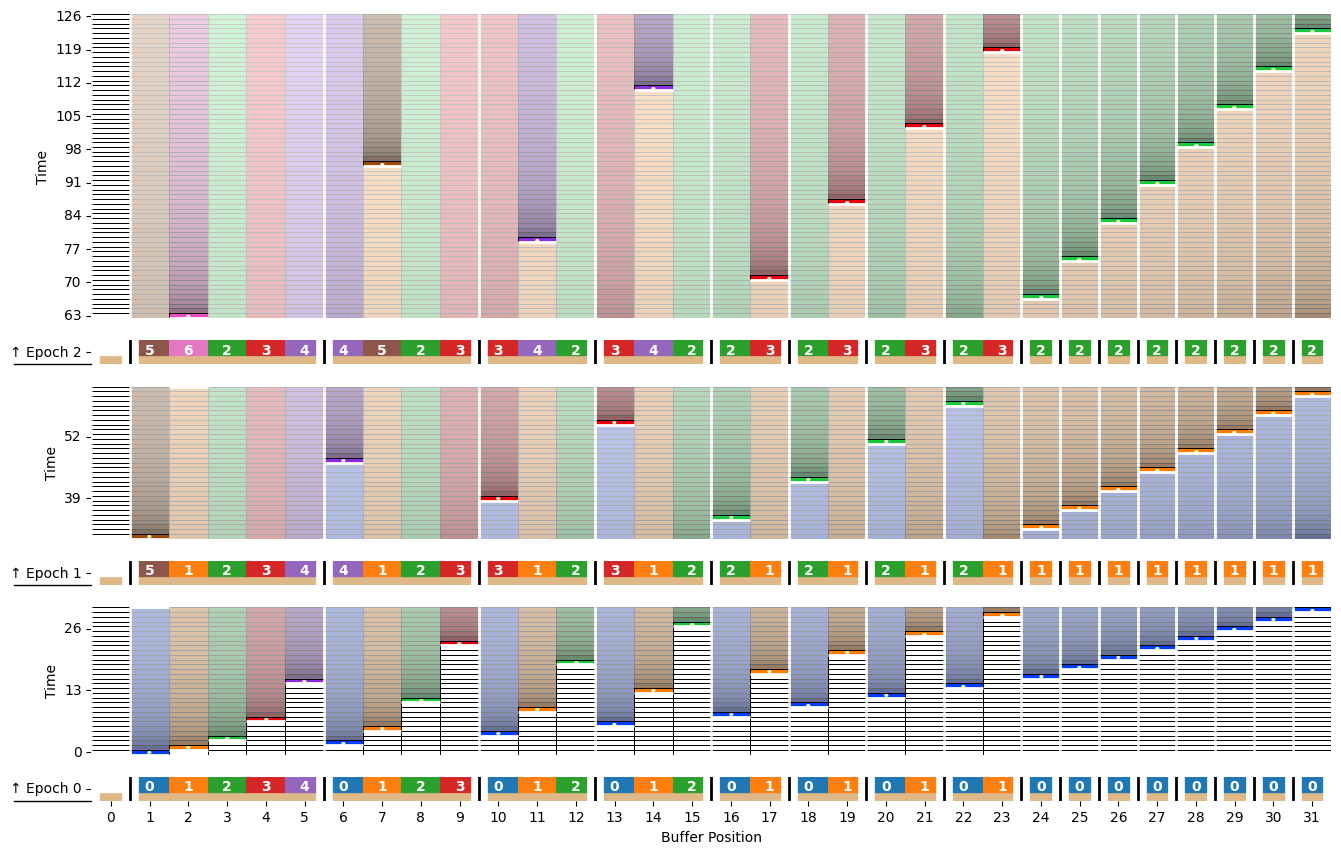

100%|██████████| 255/255 [00:00<00:00, 83408.53it/s]
4it [00:11,  2.93s/it]
4it [00:02,  1.98it/s]


teeplots/11/num-generations=256+reservation-mode=steady+surface-size=32+viz=site-reservation-by-rank-spliced-at-heatmap+ext=.pdf
teeplots/11/num-generations=256+reservation-mode=steady+surface-size=32+viz=site-reservation-by-rank-spliced-at-heatmap+ext=.png


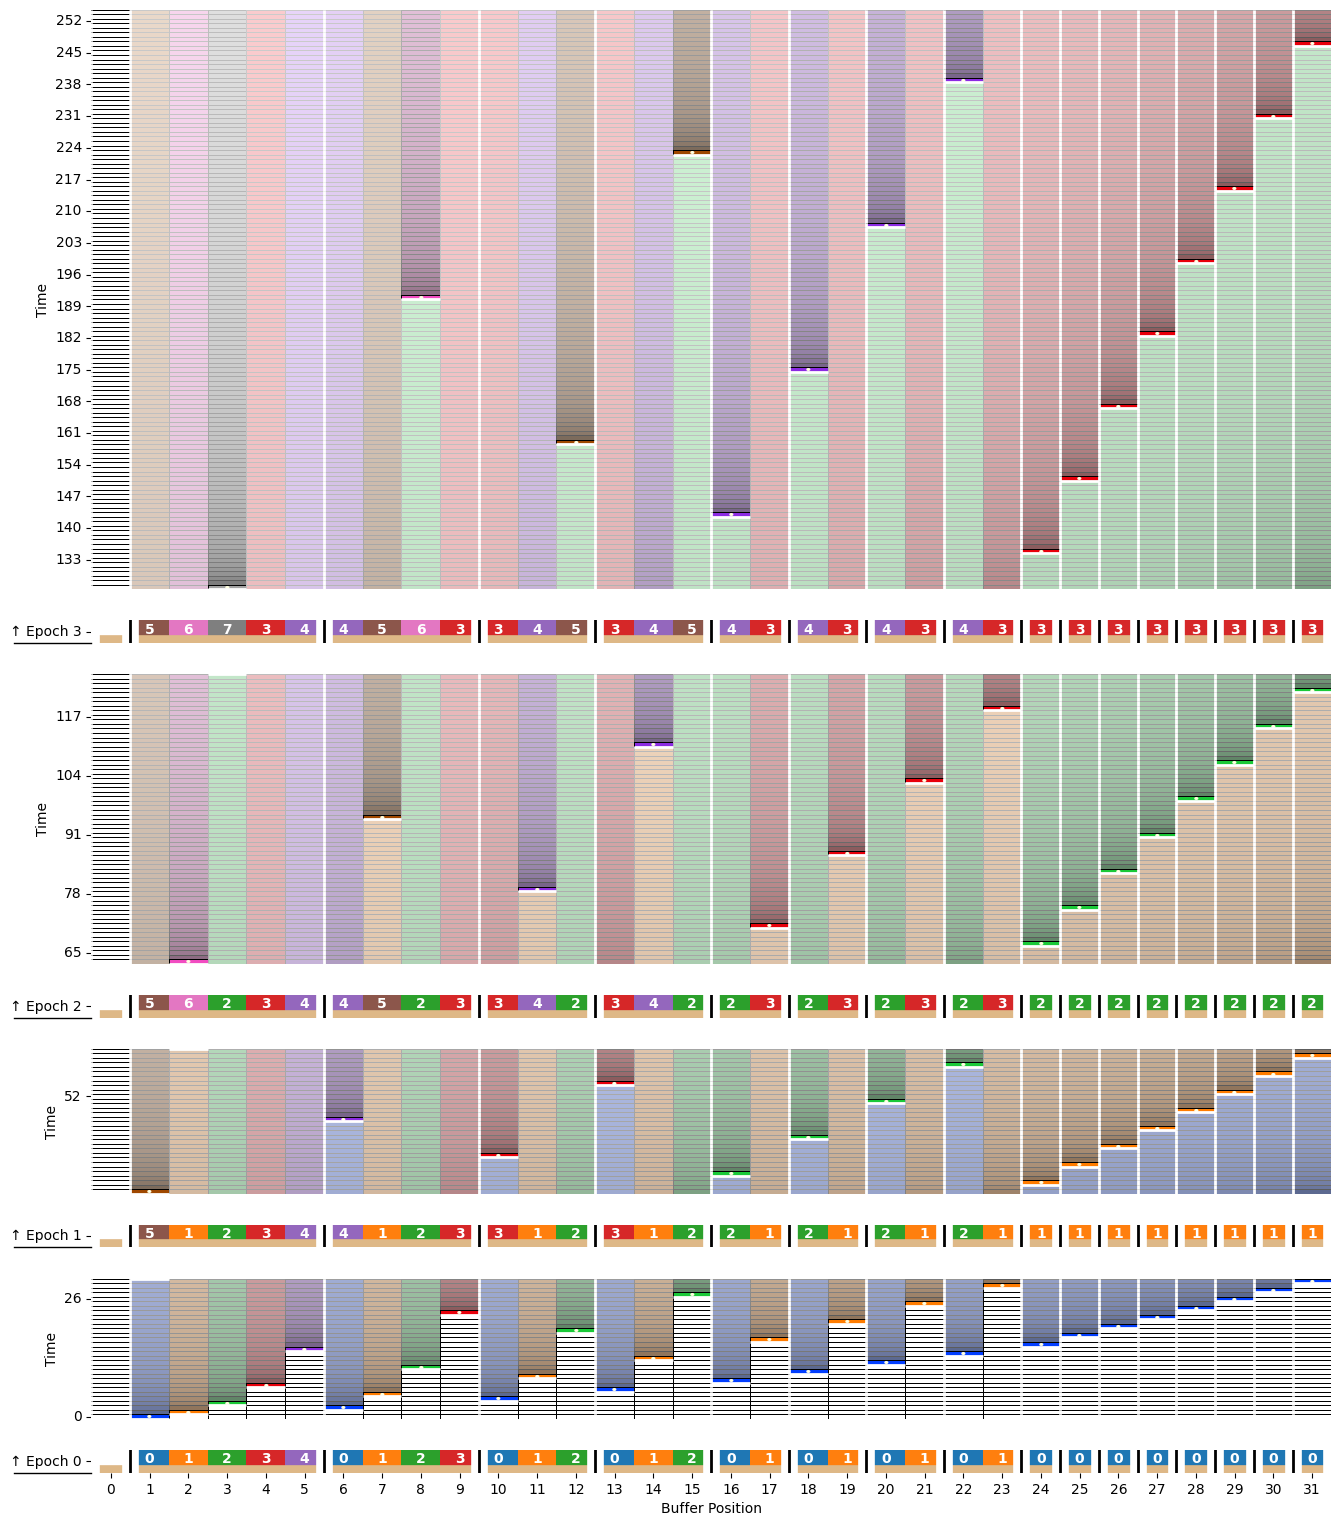

In [6]:
for num_generations, surface_size in [
    (128, 32),
    (256, 32),
]:
    surface_history_df = pylib.site_selection_eval.make_surface_history_df(
        steady_algo.pick_ingest_site,
        surface_size=surface_size,
        num_generations=num_generations - 1,
        progress_wrap=tqdm,
    ).replace(-1, np.nan)

    mpl.rcParams.update(
        {
            "figure.figsize": (surface_size / 4 + 1, num_generations / 15 + 1),
        },
    )
    candidate_ranks = [
        2**x - 2 for x in range(surface_size.bit_length() - 1, surface_size)
    ]
    maxrank = surface_history_df["rank"].max()
    ranks = [
        rank
        for rank in candidate_ranks
        if rank <= maxrank  # in operator weird, nan?
    ]
    splice_from_ranks = [rank - 2**i + 1 for i, rank in enumerate(ranks)]
    splice_to_ranks = np.array([-1, *ranks[:-1]]) + 1
    pylib.tee_release(
        pylib.site_selection_viz.site_reservation_by_rank_spliced_at_heatmap,
        surface_history_df,
        reservation_mode="steady",
        splice_from_ranks=splice_from_ranks,
        splice_to_ranks=splice_to_ranks,
        teeplot_outattrs={
            "num-generations": num_generations,
            "surface-size": surface_size,
        },
        teeplot_subdir="11",
    )
    plt.show()


100%|██████████| 128/128 [00:00<00:00, 72101.92it/s]


teeplots/11/num-generations=128+reservation-mode=steady+surface-size=32+viz=site-reservation-by-rank-heatmap+ext=.pdf
teeplots/11/num-generations=128+reservation-mode=steady+surface-size=32+viz=site-reservation-by-rank-heatmap+ext=.png


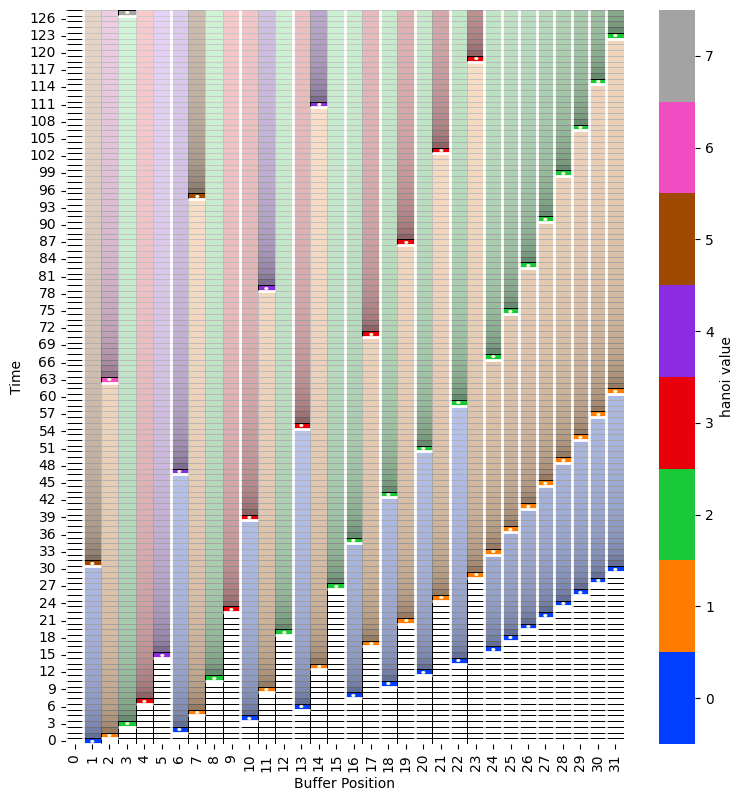

100%|██████████| 128/128 [00:00<00:00, 91977.20it/s]


teeplots/11/num-generations=128+reservation-mode=steady+surface-size=16+viz=site-reservation-by-rank-heatmap+ext=.pdf
teeplots/11/num-generations=128+reservation-mode=steady+surface-size=16+viz=site-reservation-by-rank-heatmap+ext=.png


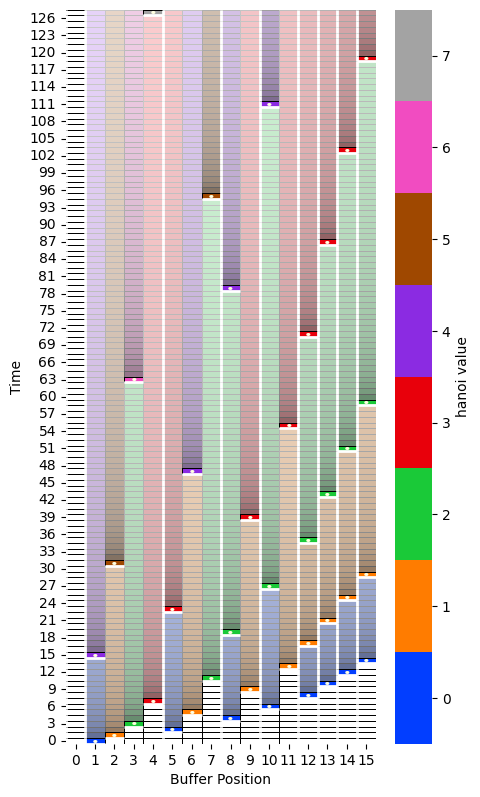

100%|██████████| 64/64 [00:00<00:00, 103165.05it/s]


teeplots/11/num-generations=64+reservation-mode=steady+surface-size=16+viz=site-reservation-by-rank-heatmap+ext=.pdf
teeplots/11/num-generations=64+reservation-mode=steady+surface-size=16+viz=site-reservation-by-rank-heatmap+ext=.png


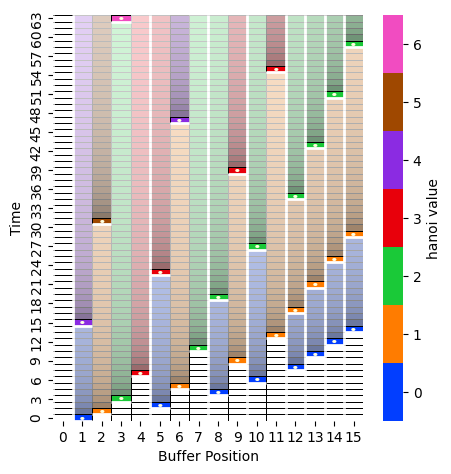

100%|██████████| 32/32 [00:00<00:00, 63580.16it/s]


teeplots/11/num-generations=32+reservation-mode=steady+surface-size=16+viz=site-reservation-by-rank-heatmap+ext=.pdf
teeplots/11/num-generations=32+reservation-mode=steady+surface-size=16+viz=site-reservation-by-rank-heatmap+ext=.png


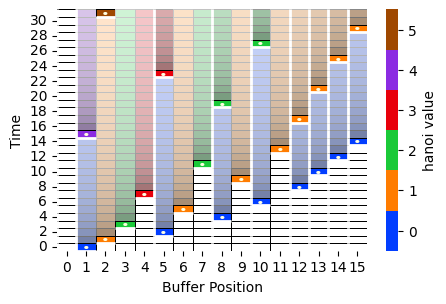

100%|██████████| 255/255 [00:00<00:00, 203878.67it/s]


teeplots/11/num-generations=255+reservation-mode=steady+surface-size=8+viz=site-reservation-by-rank-heatmap+ext=.pdf
teeplots/11/num-generations=255+reservation-mode=steady+surface-size=8+viz=site-reservation-by-rank-heatmap+ext=.png


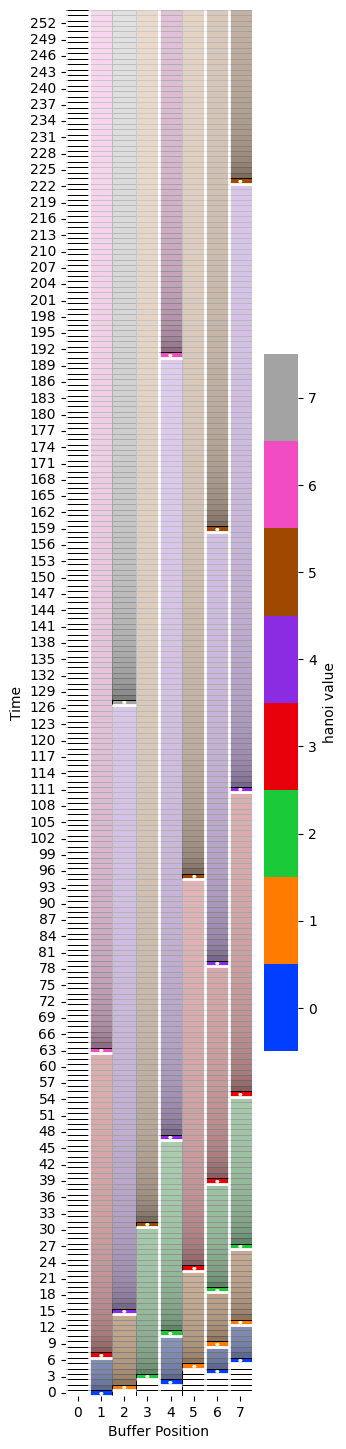

In [7]:
for num_generations, surface_size in [
    (128, 32),
    (128, 16),
    (64, 16),
    (32, 16),
    (255, 8),
]:
    surface_history_df = pylib.site_selection_eval.make_surface_history_df(
        steady_algo.pick_ingest_site,
        surface_size=surface_size,
        num_generations=num_generations,
        progress_wrap=tqdm,
    ).replace(-1, np.nan)

    mpl.rcParams.update(
        {
            "figure.figsize": (surface_size / 4 + 1, num_generations / 15 + 1),
        },
    )
    pylib.tee_release(
        pylib.site_selection_viz.site_reservation_by_rank_heatmap,
        surface_history_df,
        reservation_mode="steady",
        teeplot_outattrs={
            "num-generations": num_generations,
            "surface-size": surface_size,
        },
        teeplot_subdir="11",
    )
    plt.show()


## Section 2c: Visualize


In [8]:
mpl.rcParams.update(
    {
        "figure.figsize": (6, 1),
    },
)


100%|██████████| 262144/262144 [00:01<00:00, 226870.99it/s]


teeplots/11/num-generations=262144+surface-size=8+viz=site-differentia-by-rank-heatmap+ynorm=log+ext=.pdf
teeplots/11/num-generations=262144+surface-size=8+viz=site-differentia-by-rank-heatmap+ynorm=log+ext=.png


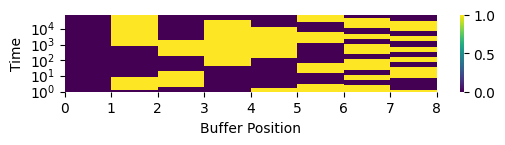

teeplots/11/num-generations=262144+surface-size=8+viz=site-differentia-by-rank-heatmap+ynorm=linear+ext=.pdf
teeplots/11/num-generations=262144+surface-size=8+viz=site-differentia-by-rank-heatmap+ynorm=linear+ext=.png


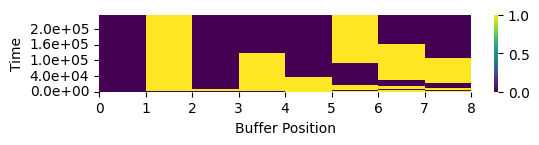

teeplots/11/cnorm=log+num-generations=262144+surface-size=8+viz=site-ingest-rank-by-rank-heatmap+ynorm=log+ext=.pdf
teeplots/11/cnorm=log+num-generations=262144+surface-size=8+viz=site-ingest-rank-by-rank-heatmap+ynorm=log+ext=.png


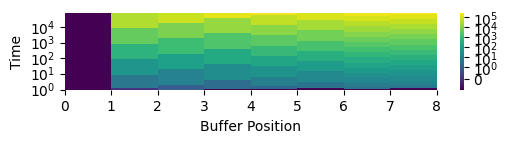

teeplots/11/cnorm=None+num-generations=262144+surface-size=8+viz=site-ingest-rank-by-rank-heatmap+ynorm=linear+ext=.pdf
teeplots/11/cnorm=None+num-generations=262144+surface-size=8+viz=site-ingest-rank-by-rank-heatmap+ynorm=linear+ext=.png


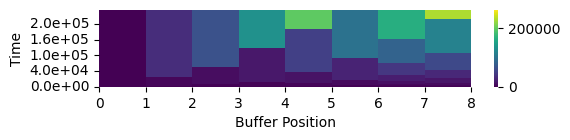

teeplots/11/num-generations=262144+surface-size=8+viz=site-hanoi-value-by-rank-heatmap+ext=.pdf
teeplots/11/num-generations=262144+surface-size=8+viz=site-hanoi-value-by-rank-heatmap+ext=.png


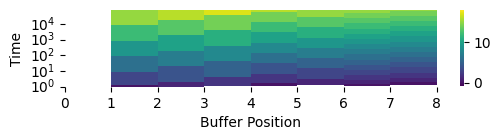

teeplots/11/num-generations=262144+surface-size=8+viz=site-hanoi-value-by-rank-heatmap+ynorm=linear+ext=.pdf
teeplots/11/num-generations=262144+surface-size=8+viz=site-hanoi-value-by-rank-heatmap+ynorm=linear+ext=.png


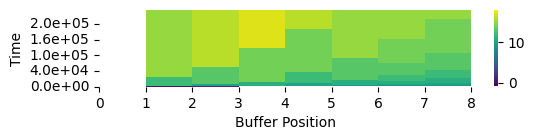

teeplots/11/cnorm=log+num-generations=262144+surface-size=8+viz=site-ingest-depth-by-rank-heatmap+ynorm=log+ext=.pdf
teeplots/11/cnorm=log+num-generations=262144+surface-size=8+viz=site-ingest-depth-by-rank-heatmap+ynorm=log+ext=.png


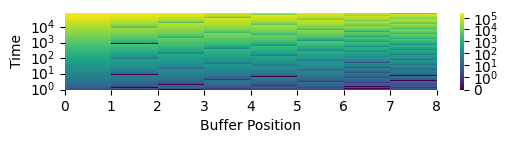

teeplots/11/cnorm=log+num-generations=262144+surface-size=8+viz=site-ingest-depth-by-rank-heatmap+ynorm=linear+ext=.pdf
teeplots/11/cnorm=log+num-generations=262144+surface-size=8+viz=site-ingest-depth-by-rank-heatmap+ynorm=linear+ext=.png


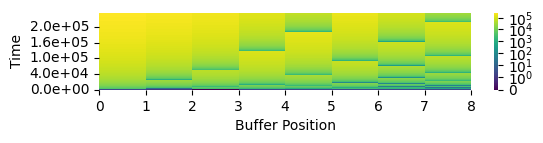

100%|██████████| 2998/2998 [00:02<00:00, 1294.10it/s]


teeplots/11/num-generations=262144+surface-size=8+viz=stratum-persistence-dripplot+ext=.pdf
teeplots/11/num-generations=262144+surface-size=8+viz=stratum-persistence-dripplot+ext=.png


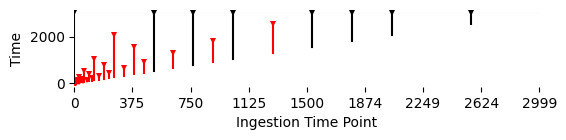

100%|██████████| 262144/262144 [00:01<00:00, 136230.55it/s]


teeplots/11/num-generations=262144+surface-size=16+viz=site-differentia-by-rank-heatmap+ynorm=log+ext=.pdf
teeplots/11/num-generations=262144+surface-size=16+viz=site-differentia-by-rank-heatmap+ynorm=log+ext=.png


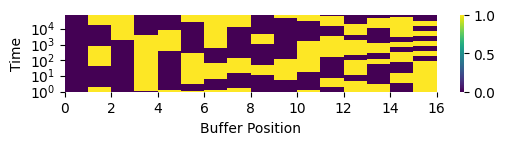

teeplots/11/num-generations=262144+surface-size=16+viz=site-differentia-by-rank-heatmap+ynorm=linear+ext=.pdf
teeplots/11/num-generations=262144+surface-size=16+viz=site-differentia-by-rank-heatmap+ynorm=linear+ext=.png


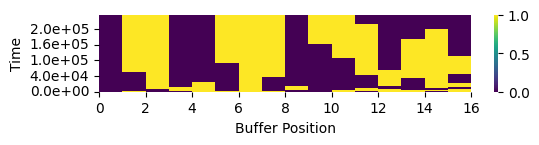

teeplots/11/cnorm=log+num-generations=262144+surface-size=16+viz=site-ingest-rank-by-rank-heatmap+ynorm=log+ext=.pdf
teeplots/11/cnorm=log+num-generations=262144+surface-size=16+viz=site-ingest-rank-by-rank-heatmap+ynorm=log+ext=.png


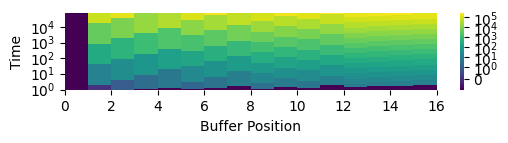

teeplots/11/cnorm=None+num-generations=262144+surface-size=16+viz=site-ingest-rank-by-rank-heatmap+ynorm=linear+ext=.pdf
teeplots/11/cnorm=None+num-generations=262144+surface-size=16+viz=site-ingest-rank-by-rank-heatmap+ynorm=linear+ext=.png


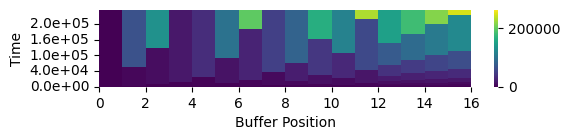

teeplots/11/num-generations=262144+surface-size=16+viz=site-hanoi-value-by-rank-heatmap+ext=.pdf
teeplots/11/num-generations=262144+surface-size=16+viz=site-hanoi-value-by-rank-heatmap+ext=.png


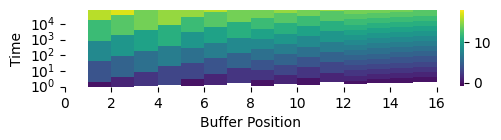

teeplots/11/num-generations=262144+surface-size=16+viz=site-hanoi-value-by-rank-heatmap+ynorm=linear+ext=.pdf
teeplots/11/num-generations=262144+surface-size=16+viz=site-hanoi-value-by-rank-heatmap+ynorm=linear+ext=.png


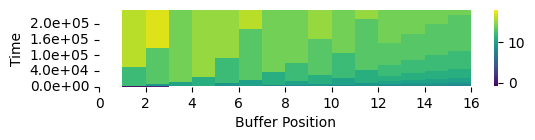

teeplots/11/cnorm=log+num-generations=262144+surface-size=16+viz=site-ingest-depth-by-rank-heatmap+ynorm=log+ext=.pdf
teeplots/11/cnorm=log+num-generations=262144+surface-size=16+viz=site-ingest-depth-by-rank-heatmap+ynorm=log+ext=.png


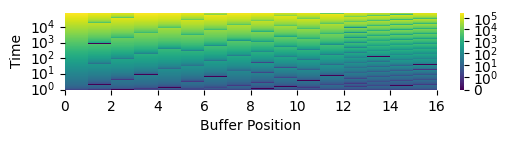

teeplots/11/cnorm=log+num-generations=262144+surface-size=16+viz=site-ingest-depth-by-rank-heatmap+ynorm=linear+ext=.pdf
teeplots/11/cnorm=log+num-generations=262144+surface-size=16+viz=site-ingest-depth-by-rank-heatmap+ynorm=linear+ext=.png


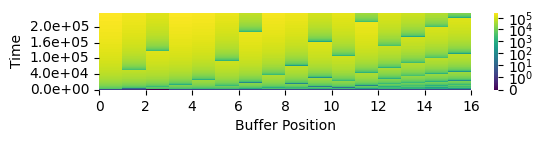

100%|██████████| 2998/2998 [00:02<00:00, 1210.09it/s]


teeplots/11/num-generations=262144+surface-size=16+viz=stratum-persistence-dripplot+ext=.pdf
teeplots/11/num-generations=262144+surface-size=16+viz=stratum-persistence-dripplot+ext=.png


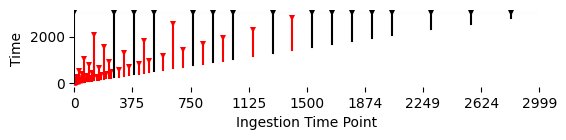

100%|██████████| 262144/262144 [00:03<00:00, 75689.34it/s]


teeplots/11/num-generations=262144+surface-size=32+viz=site-differentia-by-rank-heatmap+ynorm=log+ext=.pdf
teeplots/11/num-generations=262144+surface-size=32+viz=site-differentia-by-rank-heatmap+ynorm=log+ext=.png


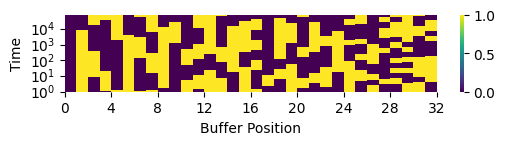

teeplots/11/num-generations=262144+surface-size=32+viz=site-differentia-by-rank-heatmap+ynorm=linear+ext=.pdf
teeplots/11/num-generations=262144+surface-size=32+viz=site-differentia-by-rank-heatmap+ynorm=linear+ext=.png


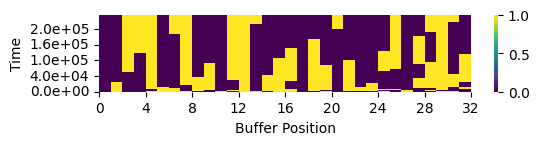

teeplots/11/cnorm=log+num-generations=262144+surface-size=32+viz=site-ingest-rank-by-rank-heatmap+ynorm=log+ext=.pdf
teeplots/11/cnorm=log+num-generations=262144+surface-size=32+viz=site-ingest-rank-by-rank-heatmap+ynorm=log+ext=.png


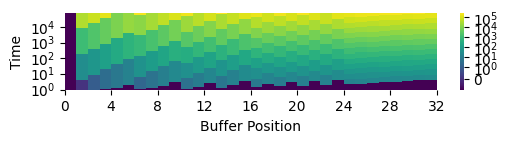

teeplots/11/cnorm=None+num-generations=262144+surface-size=32+viz=site-ingest-rank-by-rank-heatmap+ynorm=linear+ext=.pdf
teeplots/11/cnorm=None+num-generations=262144+surface-size=32+viz=site-ingest-rank-by-rank-heatmap+ynorm=linear+ext=.png


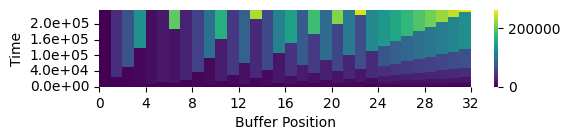

teeplots/11/num-generations=262144+surface-size=32+viz=site-hanoi-value-by-rank-heatmap+ext=.pdf
teeplots/11/num-generations=262144+surface-size=32+viz=site-hanoi-value-by-rank-heatmap+ext=.png


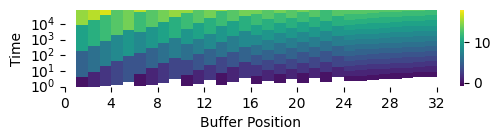

teeplots/11/num-generations=262144+surface-size=32+viz=site-hanoi-value-by-rank-heatmap+ynorm=linear+ext=.pdf
teeplots/11/num-generations=262144+surface-size=32+viz=site-hanoi-value-by-rank-heatmap+ynorm=linear+ext=.png


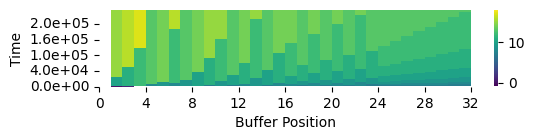

teeplots/11/cnorm=log+num-generations=262144+surface-size=32+viz=site-ingest-depth-by-rank-heatmap+ynorm=log+ext=.pdf
teeplots/11/cnorm=log+num-generations=262144+surface-size=32+viz=site-ingest-depth-by-rank-heatmap+ynorm=log+ext=.png


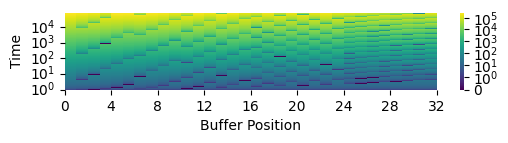

teeplots/11/cnorm=log+num-generations=262144+surface-size=32+viz=site-ingest-depth-by-rank-heatmap+ynorm=linear+ext=.pdf
teeplots/11/cnorm=log+num-generations=262144+surface-size=32+viz=site-ingest-depth-by-rank-heatmap+ynorm=linear+ext=.png


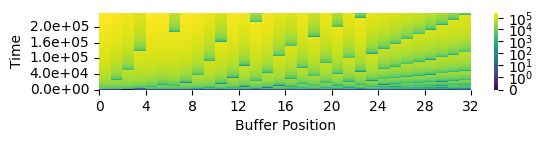

100%|██████████| 2998/2998 [00:02<00:00, 1094.16it/s]


teeplots/11/num-generations=262144+surface-size=32+viz=stratum-persistence-dripplot+ext=.pdf
teeplots/11/num-generations=262144+surface-size=32+viz=stratum-persistence-dripplot+ext=.png


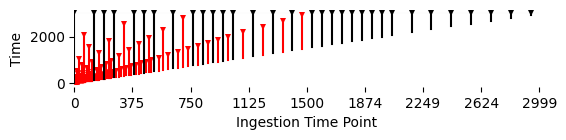

100%|██████████| 262144/262144 [00:06<00:00, 39914.71it/s]


teeplots/11/num-generations=262144+surface-size=64+viz=site-differentia-by-rank-heatmap+ynorm=log+ext=.pdf
teeplots/11/num-generations=262144+surface-size=64+viz=site-differentia-by-rank-heatmap+ynorm=log+ext=.png


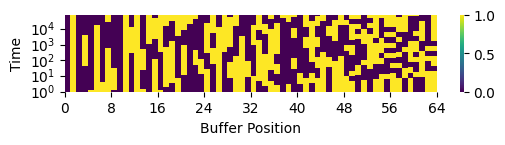

teeplots/11/num-generations=262144+surface-size=64+viz=site-differentia-by-rank-heatmap+ynorm=linear+ext=.pdf
teeplots/11/num-generations=262144+surface-size=64+viz=site-differentia-by-rank-heatmap+ynorm=linear+ext=.png


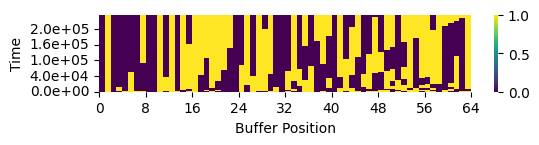

teeplots/11/cnorm=log+num-generations=262144+surface-size=64+viz=site-ingest-rank-by-rank-heatmap+ynorm=log+ext=.pdf
teeplots/11/cnorm=log+num-generations=262144+surface-size=64+viz=site-ingest-rank-by-rank-heatmap+ynorm=log+ext=.png


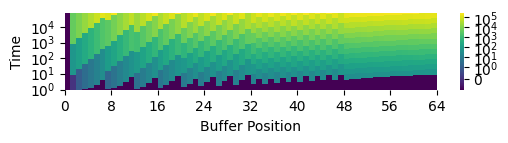

teeplots/11/cnorm=None+num-generations=262144+surface-size=64+viz=site-ingest-rank-by-rank-heatmap+ynorm=linear+ext=.pdf
teeplots/11/cnorm=None+num-generations=262144+surface-size=64+viz=site-ingest-rank-by-rank-heatmap+ynorm=linear+ext=.png


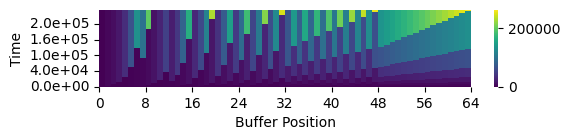

teeplots/11/num-generations=262144+surface-size=64+viz=site-hanoi-value-by-rank-heatmap+ext=.pdf
teeplots/11/num-generations=262144+surface-size=64+viz=site-hanoi-value-by-rank-heatmap+ext=.png


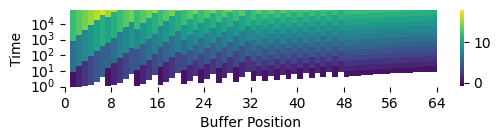

teeplots/11/num-generations=262144+surface-size=64+viz=site-hanoi-value-by-rank-heatmap+ynorm=linear+ext=.pdf
teeplots/11/num-generations=262144+surface-size=64+viz=site-hanoi-value-by-rank-heatmap+ynorm=linear+ext=.png


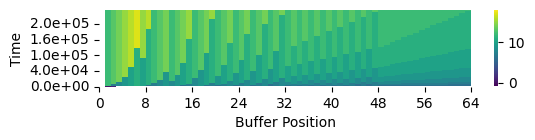

teeplots/11/cnorm=log+num-generations=262144+surface-size=64+viz=site-ingest-depth-by-rank-heatmap+ynorm=log+ext=.pdf
teeplots/11/cnorm=log+num-generations=262144+surface-size=64+viz=site-ingest-depth-by-rank-heatmap+ynorm=log+ext=.png


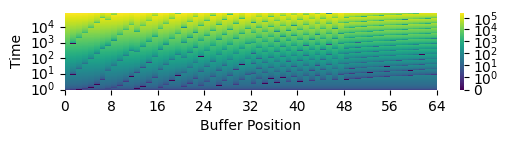

teeplots/11/cnorm=log+num-generations=262144+surface-size=64+viz=site-ingest-depth-by-rank-heatmap+ynorm=linear+ext=.pdf
teeplots/11/cnorm=log+num-generations=262144+surface-size=64+viz=site-ingest-depth-by-rank-heatmap+ynorm=linear+ext=.png


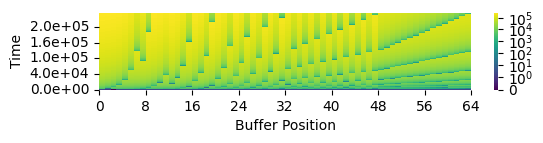

100%|██████████| 2998/2998 [00:03<00:00, 872.80it/s]


teeplots/11/num-generations=262144+surface-size=64+viz=stratum-persistence-dripplot+ext=.pdf
teeplots/11/num-generations=262144+surface-size=64+viz=stratum-persistence-dripplot+ext=.png


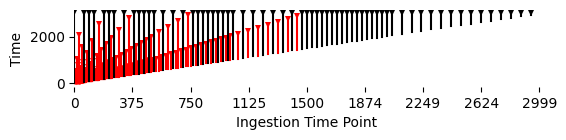

100%|██████████| 4096/4096 [00:00<00:00, 32366.48it/s]


teeplots/11/num-generations=4096+surface-size=128+viz=site-differentia-by-rank-heatmap+ynorm=log+ext=.pdf
teeplots/11/num-generations=4096+surface-size=128+viz=site-differentia-by-rank-heatmap+ynorm=log+ext=.png


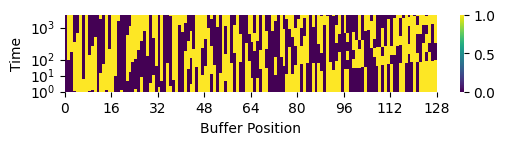

teeplots/11/num-generations=4096+surface-size=128+viz=site-differentia-by-rank-heatmap+ynorm=linear+ext=.pdf
teeplots/11/num-generations=4096+surface-size=128+viz=site-differentia-by-rank-heatmap+ynorm=linear+ext=.png


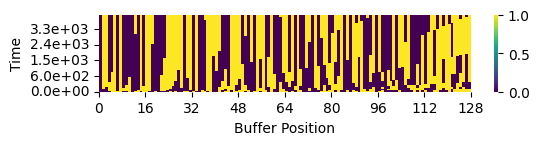

teeplots/11/cnorm=log+num-generations=4096+surface-size=128+viz=site-ingest-rank-by-rank-heatmap+ynorm=log+ext=.pdf
teeplots/11/cnorm=log+num-generations=4096+surface-size=128+viz=site-ingest-rank-by-rank-heatmap+ynorm=log+ext=.png


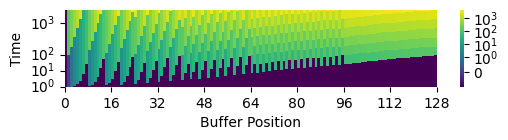

teeplots/11/cnorm=None+num-generations=4096+surface-size=128+viz=site-ingest-rank-by-rank-heatmap+ynorm=linear+ext=.pdf
teeplots/11/cnorm=None+num-generations=4096+surface-size=128+viz=site-ingest-rank-by-rank-heatmap+ynorm=linear+ext=.png


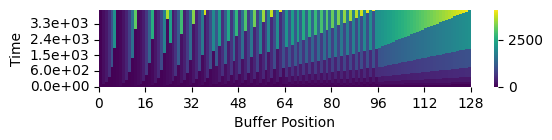

teeplots/11/num-generations=4096+surface-size=128+viz=site-hanoi-value-by-rank-heatmap+ext=.pdf
teeplots/11/num-generations=4096+surface-size=128+viz=site-hanoi-value-by-rank-heatmap+ext=.png


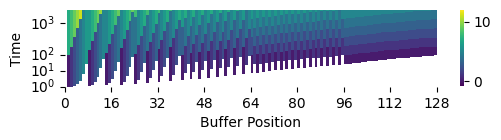

teeplots/11/num-generations=4096+surface-size=128+viz=site-hanoi-value-by-rank-heatmap+ynorm=linear+ext=.pdf
teeplots/11/num-generations=4096+surface-size=128+viz=site-hanoi-value-by-rank-heatmap+ynorm=linear+ext=.png


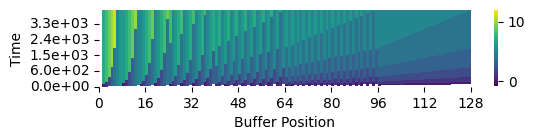

teeplots/11/cnorm=log+num-generations=4096+surface-size=128+viz=site-ingest-depth-by-rank-heatmap+ynorm=log+ext=.pdf
teeplots/11/cnorm=log+num-generations=4096+surface-size=128+viz=site-ingest-depth-by-rank-heatmap+ynorm=log+ext=.png


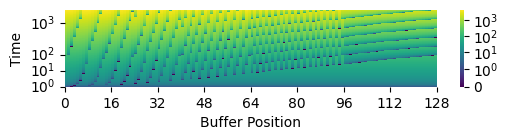

teeplots/11/cnorm=log+num-generations=4096+surface-size=128+viz=site-ingest-depth-by-rank-heatmap+ynorm=linear+ext=.pdf
teeplots/11/cnorm=log+num-generations=4096+surface-size=128+viz=site-ingest-depth-by-rank-heatmap+ynorm=linear+ext=.png


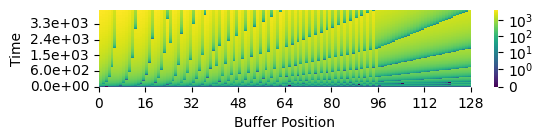

100%|██████████| 2998/2998 [00:04<00:00, 653.15it/s]


teeplots/11/num-generations=4096+surface-size=128+viz=stratum-persistence-dripplot+ext=.pdf
teeplots/11/num-generations=4096+surface-size=128+viz=stratum-persistence-dripplot+ext=.png


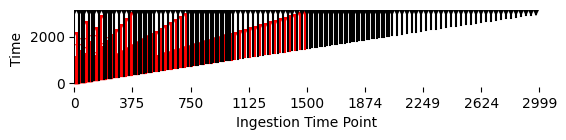

100%|██████████| 4096/4096 [00:00<00:00, 12833.62it/s]


teeplots/11/num-generations=4096+surface-size=256+viz=site-differentia-by-rank-heatmap+ynorm=log+ext=.pdf
teeplots/11/num-generations=4096+surface-size=256+viz=site-differentia-by-rank-heatmap+ynorm=log+ext=.png


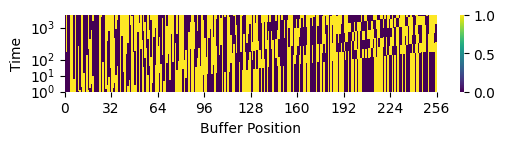

teeplots/11/num-generations=4096+surface-size=256+viz=site-differentia-by-rank-heatmap+ynorm=linear+ext=.pdf
teeplots/11/num-generations=4096+surface-size=256+viz=site-differentia-by-rank-heatmap+ynorm=linear+ext=.png


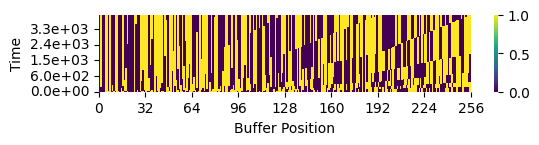

teeplots/11/cnorm=log+num-generations=4096+surface-size=256+viz=site-ingest-rank-by-rank-heatmap+ynorm=log+ext=.pdf
teeplots/11/cnorm=log+num-generations=4096+surface-size=256+viz=site-ingest-rank-by-rank-heatmap+ynorm=log+ext=.png


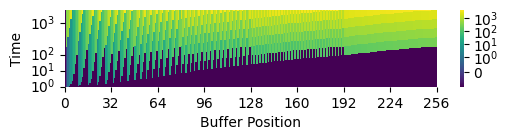

teeplots/11/cnorm=None+num-generations=4096+surface-size=256+viz=site-ingest-rank-by-rank-heatmap+ynorm=linear+ext=.pdf
teeplots/11/cnorm=None+num-generations=4096+surface-size=256+viz=site-ingest-rank-by-rank-heatmap+ynorm=linear+ext=.png


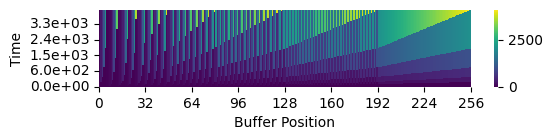

teeplots/11/num-generations=4096+surface-size=256+viz=site-hanoi-value-by-rank-heatmap+ext=.pdf
teeplots/11/num-generations=4096+surface-size=256+viz=site-hanoi-value-by-rank-heatmap+ext=.png


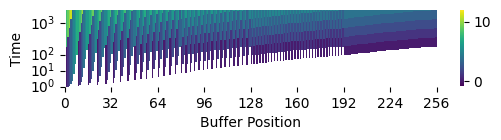

teeplots/11/num-generations=4096+surface-size=256+viz=site-hanoi-value-by-rank-heatmap+ynorm=linear+ext=.pdf
teeplots/11/num-generations=4096+surface-size=256+viz=site-hanoi-value-by-rank-heatmap+ynorm=linear+ext=.png


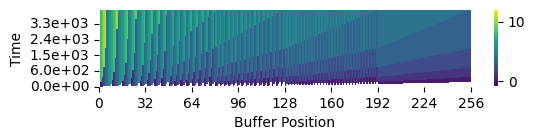

teeplots/11/cnorm=log+num-generations=4096+surface-size=256+viz=site-ingest-depth-by-rank-heatmap+ynorm=log+ext=.pdf
teeplots/11/cnorm=log+num-generations=4096+surface-size=256+viz=site-ingest-depth-by-rank-heatmap+ynorm=log+ext=.png


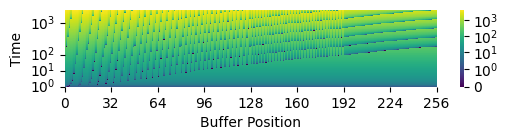

teeplots/11/cnorm=log+num-generations=4096+surface-size=256+viz=site-ingest-depth-by-rank-heatmap+ynorm=linear+ext=.pdf
teeplots/11/cnorm=log+num-generations=4096+surface-size=256+viz=site-ingest-depth-by-rank-heatmap+ynorm=linear+ext=.png


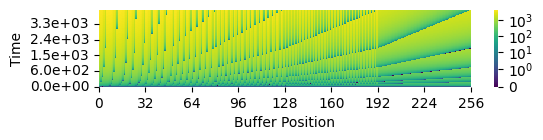

100%|██████████| 2998/2998 [00:06<00:00, 475.07it/s]


teeplots/11/num-generations=4096+surface-size=256+viz=stratum-persistence-dripplot+ext=.pdf
teeplots/11/num-generations=4096+surface-size=256+viz=stratum-persistence-dripplot+ext=.png


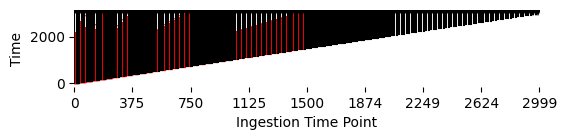

In [9]:
for surface_size_exp in range(3, 9):
    surface_size = 2**surface_size_exp
    display(HTML(f"<h3>surface size {surface_size}</h3>"))

    # don't run out of memory
    num_generations = 2**18 if surface_size_exp < 7 else 2**12

    surface_history_df = pylib.site_selection_eval.make_surface_history_df(
        steady_algo.pick_ingest_site,
        surface_size=surface_size,
        num_generations=num_generations,
        progress_wrap=tqdm,
    )

    # ========================
    kwargs = dict(
        ynorm="log",
    )
    pylib.tee_release(
        pylib.site_selection_viz.site_differentia_by_rank_heatmap,
        surface_history_df,
        **kwargs,
        teeplot_outattrs={
            **{
                "num-generations": num_generations,
                "surface-size": surface_size,
            },
            **kwargs,
        },
        teeplot_subdir="11",
    )

    # ========================
    kwargs = dict(
        ynorm="linear",
    )
    pylib.tee_release(
        pylib.site_selection_viz.site_differentia_by_rank_heatmap,
        surface_history_df,
        **kwargs,
        teeplot_outattrs={
            **{
                "num-generations": num_generations,
                "surface-size": surface_size,
            },
            **kwargs,
        },
        teeplot_subdir="11",
    )

    # ========================
    kwargs = dict(
        cnorm="log",
        ynorm="log",
    )
    pylib.tee_release(
        pylib.site_selection_viz.site_ingest_rank_by_rank_heatmap,
        surface_history_df,
        **kwargs,
        teeplot_outattrs={
            **{
                "num-generations": num_generations,
                "surface-size": surface_size,
            },
            **kwargs,
        },
        teeplot_subdir="11",
    )

    # ========================
    kwargs = dict(
        cnorm=None,
        ynorm="linear",
    )
    pylib.tee_release(
        pylib.site_selection_viz.site_ingest_rank_by_rank_heatmap,
        surface_history_df,
        **kwargs,
        teeplot_outattrs={
            **{
                "num-generations": num_generations,
                "surface-size": surface_size,
            },
            **kwargs,
        },
        teeplot_subdir="11",
    )

    # ========================
    pylib.tee_release(
        pylib.site_selection_viz.site_hanoi_value_by_rank_heatmap,
        surface_history_df,
        teeplot_outattrs={
            "num-generations": num_generations,
            "surface-size": surface_size,
        },
        teeplot_subdir="11",
    )

    # ========================
    kwargs = dict(
        ynorm="linear",
    )
    pylib.tee_release(
        pylib.site_selection_viz.site_hanoi_value_by_rank_heatmap,
        surface_history_df,
        **kwargs,
        teeplot_outattrs={
            **{
                "num-generations": num_generations,
                "surface-size": surface_size,
            },
            **kwargs,
        },
        teeplot_subdir="11",
    )

    # ========================
    kwargs = dict(
        cnorm="log",
        ynorm="log",
    )
    pylib.tee_release(
        pylib.site_selection_viz.site_ingest_depth_by_rank_heatmap,
        surface_history_df,
        **kwargs,
        teeplot_outattrs={
            **{
                "num-generations": num_generations,
                "surface-size": surface_size,
            },
            **kwargs,
        },
        teeplot_subdir="11",
    )

    # ========================
    kwargs = dict(
        cnorm="log",
        ynorm="linear",
    )
    pylib.tee_release(
        pylib.site_selection_viz.site_ingest_depth_by_rank_heatmap,
        surface_history_df,
        **kwargs,
        teeplot_outattrs={
            **{
                "num-generations": num_generations,
                "surface-size": surface_size,
            },
            **kwargs,
        },
        teeplot_subdir="11",
    )

    # ========================
    pylib.tee_release(
        pylib.site_selection_viz.stratum_persistence_dripplot,
        surface_history_df[surface_history_df["rank"] < 3000],
        teeplot_outattrs={
            "num-generations": num_generations,
            "surface-size": surface_size,
        },
        teeplot_subdir="11",
        progress_wrap=tqdm,
    )


100%|██████████| 300/300 [00:00<00:00, 83713.07it/s]


teeplots/11/hue=ingest-rank+num-generations=300+surface-size=32+viz=scatter-move-legend+x=rank+y=site+ext=.pdf
teeplots/11/hue=ingest-rank+num-generations=300+surface-size=32+viz=scatter-move-legend+x=rank+y=site+ext=.png


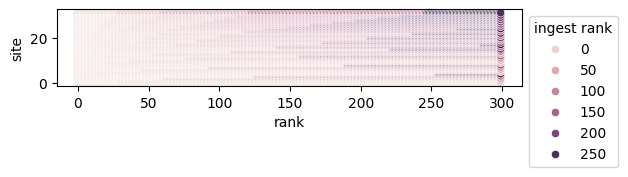

teeplots/11/hue=site+num-generations=300+surface-size=32+viz=scatter-invert+x=ingest-rank+y=rank+ext=.pdf
teeplots/11/hue=site+num-generations=300+surface-size=32+viz=scatter-invert+x=ingest-rank+y=rank+ext=.png


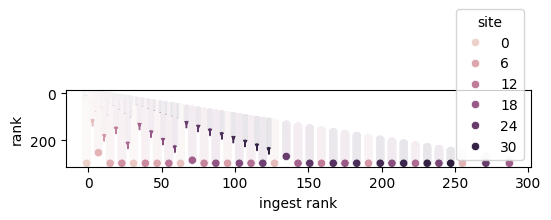

teeplots/11/hue=site+num-generations=300+surface-size=32+viz=scatter-invert-zoom+x=ingest-rank+y=rank+ext=.pdf
teeplots/11/hue=site+num-generations=300+surface-size=32+viz=scatter-invert-zoom+x=ingest-rank+y=rank+ext=.png


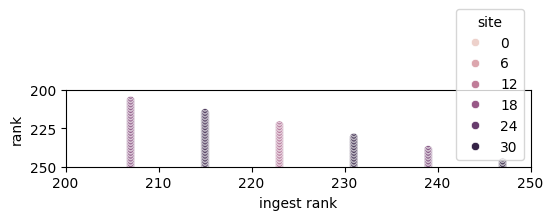

In [10]:
surface_size = 32
num_generations = 300

surface_history_df = pylib.site_selection_eval.make_surface_history_df(
    steady_algo.pick_ingest_site,
    surface_size,
    num_generations,
    tqdm,
)


# ========================
def scatter_move_legend(*args, **kwargs) -> None:
    ax = sns.scatterplot(
        *args,
        **kwargs,
    )
    sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))


pylib.tee_release(
    scatter_move_legend,
    data=surface_history_df,
    x="rank",
    y="site",
    hue="ingest rank",
    teeplot_outattrs={
        "num-generations": num_generations,
        "surface-size": surface_size,
    },
    teeplot_subdir="11",
)


# ========================
def scatter_invert(*args, **kwargs) -> None:
    sns.scatterplot(
        *args,
        **kwargs,
    ).invert_yaxis()


pylib.tee_release(
    scatter_invert,
    data=surface_history_df,
    x="ingest rank",
    y="rank",
    hue="site",
    teeplot_outattrs={
        "num-generations": num_generations,
        "surface-size": surface_size,
    },
    teeplot_subdir="11",
)


# ========================
def scatter_invert_zoom(*args, **kwargs) -> None:
    ax = sns.scatterplot(
        *args,
        **kwargs,
    )
    ax.set_xlim([200, 250])
    ax.set_ylim([200, 250])
    ax.invert_yaxis()


pylib.tee_release(
    scatter_invert_zoom,
    data=surface_history_df,
    x="ingest rank",
    y="rank",
    hue="site",
    teeplot_outattrs={
        "num-generations": num_generations,
        "surface-size": surface_size,
    },
    teeplot_subdir="11",
)
